In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import tqdm

In [60]:
def load_tint_aws(fid, loc_id, y):
    #Read the AWS-TINT output, which contains one-minute gusts merged with the closest TINT storm UID, 
    # as well as a flag for if the storm is within 0, 10 or 20 km
    df = pd.read_csv("/g/data/eg3/ab4502/TINTobjects/"+fid+"_aws.csv")
    df["hour_floor"] = pd.DatetimeIndex(df.dt_utc).floor("1H")

    #Get the severe convective gusts. Defined when there is an object within 10 km, 
    # the gust is greater than 25 m/s. Only interested in the unique "events", defined
    # by having a unique storm id. However, because the storm can change ID on shrt time 
    # scales, also constrain events to unique hours.
    scws = df.query("in10km==1").query("gust>=25").sort_values("gust",ascending=False).\
        drop_duplicates("uid").drop_duplicates("hour_floor").sort_values("dt_utc")

    #Read the storm object statistics from TINT. Merge with the SCW events, and classify
    storm2 = pd.read_csv("/g/data/eg3/ab4502/TINTobjects/"+fid+".csv")
    scws = scws.merge(storm2, on=["uid","scan"])
    scws = scws[["dt_utc","stn_id","hour_floor","scan","uid","gust","major_axis_length","minor_axis_length","local_max","azi_shear","max_alt","conv_pct"]]
    if scws.shape[0]>0:
        scws["aspect"] = scws["major_axis_length"] / scws["minor_axis_length"]
        scws.loc[(scws["major_axis_length"]>=100) & (scws["aspect"]>=3),"class"] = "Linear"
        scws.loc[(scws["major_axis_length"]>=100) & (scws["aspect"]<3),"class"] = "Non-linear"
        scws.loc[(scws["major_axis_length"]<100) & (scws["local_max"]==1),"class"] = "Cellular"
        scws.loc[(scws["major_axis_length"]<100) & (scws["local_max"]>1),"class"] = "Cell cluster"
        scws.loc[(scws["major_axis_length"]<100) & (scws["aspect"]<3) & (scws["azi_shear"]>=4.5),"class"] = "Supercellular"
        scws.loc[(scws["max_alt"]<8) & (scws["conv_pct"]<0.5),"class"] = "Shallow"

        era5 = pd.read_pickle("/g/data/eg3/ab4502/ExtremeWind/points/era5_rad50km_case_study_"+str(y)+"_"+str(y)+"_max.pkl")
        scws = scws.merge(era5[era5.loc_id==loc_id], right_on="time", left_on="hour_floor")

    return df, scws
 
def last_day_of_month(any_day):
    # get close to the end of the month for any day, and add 4 days 'over'
    next_month = any_day.replace(day=28) + dt.timedelta(days=4)
    # subtract the number of remaining 'overage' days to get last day of current month, or said programattically said, the previous day of the first of next month
    return next_month - dt.timedelta(days=next_month.day)    


# scws2 = pd.DataFrame()
# for y in np.arange(2010,2021):
#     for m in tqdm.tqdm(np.arange(1,13)):
#         try:
#             fid1 = dt.datetime(y,m,1).strftime("%Y%m%d")
#             fid2 = last_day_of_month(dt.datetime(y,m,1)).strftime("%Y%m%d")
#             temp_all, temp = load_tint_aws("2_"+fid1+"_"+fid2, "Melbourne", y)
#             scws2 = pd.concat([scws2, temp],axis=0)
#         except:
#             pass

        
scws66 = pd.DataFrame()
for y in np.arange(2010,2021):
    for m in tqdm.tqdm(np.arange(1,13)):
        try:
            fid1 = dt.datetime(y,m,1).strftime("%Y%m%d")
            fid2 = last_day_of_month(dt.datetime(y,m,1)).strftime("%Y%m%d")
            temp_all, temp = load_tint_aws("66_"+fid1+"_"+fid2, "Amberley", y)
            scws66 = pd.concat([scws66, temp],axis=0)
        except:
            pass

100%|██████████| 12/12 [00:27<00:00,  2.26s/it]


(0.0, 2000.0)

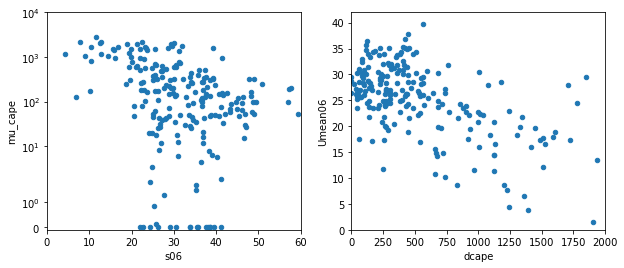

In [58]:
plt.figure(figsize=[10,4])
ax=plt.subplot(1,2,1)
scws2.plot(kind="scatter",x="s06",y="mu_cape",ax=ax); plt.yscale("symlog"); plt.ylim([-.1,10000]); plt.xlim([0,60])
ax=plt.subplot(1,2,2)
scws2.plot(kind="scatter",x="dcape",y="Umean06",ax=ax); plt.ylim([0,42]); plt.xlim([0,2000])

(0.0, 2000.0)

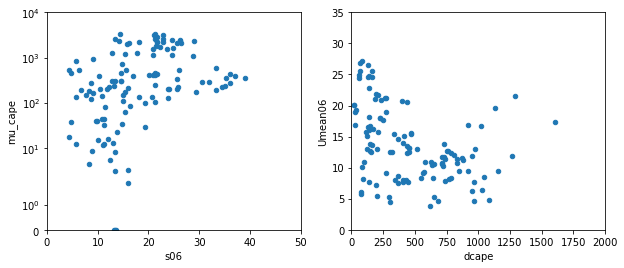

In [63]:
plt.figure(figsize=[10,4])
ax=plt.subplot(1,2,1)
scws66.plot(kind="scatter",x="s06",y="mu_cape",ax=ax); plt.yscale("symlog"); plt.ylim([0,10000]); plt.xlim([0,50])
ax=plt.subplot(1,2,2)
scws66.plot(kind="scatter",x="dcape",y="Umean06",ax=ax); plt.ylim([0,35]); plt.xlim([0,2000])

<AxesSubplot:xlabel='dcape', ylabel='gust'>

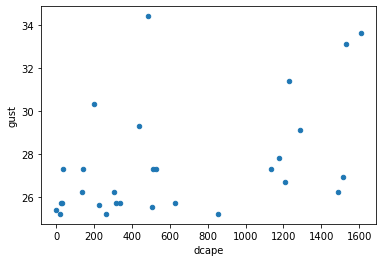

In [40]:
pd.concat([scws2,scws66],axis=0).plot(kind="scatter",x="dcape",y="gust")

In [66]:
scws66.sort_values("gust",ascending=False)[["dt_utc","stn_id","scan","uid","gust","class","mu_cape","s06","Umean06","dcape","major_axis_length","aspect","max_alt","conv_pct"]]

,dt_utc,stn_id,scan,uid,gust,class,mu_cape,s06,Umean06,dcape,major_axis_length,aspect,max_alt,conv_pct
0,2011-01-11 03:49:00,40082,2438.0,2892.0,48.4,Non-linear,1248.5625,12.812500,12.492188,321.5000,214.129,1.645956,9.0,0.427
2,2016-11-13 07:31:00,40842,2927.0,745.0,43.7,Cell cluster,2373.6250,26.289062,17.273438,1606.7500,60.834,1.708532,14.0,0.425
1,2014-11-27 06:29:00,40211,5808.0,1091.0,39.1,Supercellular,2561.6875,13.468750,4.687500,968.4375,85.672,2.178840,14.0,0.561
7,2013-01-27 04:02:00,40043,6205.0,2670.0,35.5,Shallow,177.3750,29.390625,25.539062,69.1250,220.214,1.531220,6.5,0.282
9,2013-01-27 06:36:00,40043,6228.0,2817.0,34.5,Shallow,125.7500,23.898438,24.468750,60.3125,195.472,2.170440,6.0,0.091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2016-04-24 07:25:00,40043,5107.0,1150.0,25.2,Cell cluster,171.3125,15.281250,11.515625,873.5625,43.796,3.194923,5.5,0.631
1,2016-04-24 08:15:00,40043,5115.0,1160.0,25.2,Shallow,110.3750,15.031250,11.406250,829.6250,28.603,3.587933,4.0,0.448
0,2016-06-03 18:40:00,40043,664.0,1156.0,25.2,Cellular,246.9375,21.195312,16.492188,133.2500,49.722,1.701293,5.0,0.543
1,2016-06-03 19:14:00,40043,670.0,1198.0,25.2,Non-linear,197.3750,23.890625,15.820312,118.9375,123.180,1.764327,7.0,0.546


<AxesSubplot:>

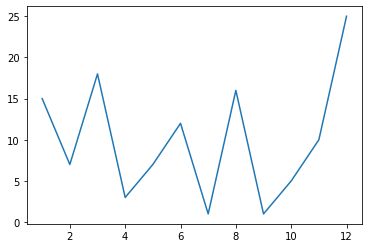

In [64]:
pd.DatetimeIndex(scws66["dt_utc"]).month.value_counts().sort_index().plot()

In [69]:
scws66["class"].value_counts()

Shallow          54
Cellular         22
Cell cluster     20
Non-linear       13
Supercellular     7
Linear            4
Name: class, dtype: int64